# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import sys
sys.path.append('/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc')
import scme, utils

In [13]:
data_path = '/wynton/group/ye/mincheol/parameter_estimation/'

### Read the IFN AnnData object

In [10]:
ifn_adata = sc.read(data_path + 'interferon_data/interferon.raw.h5ad')
ifn_adata = ifn_adata[:, ifn_adata.var.index.map(lambda x: x[:2] != 'HB')]
ifn_adata.obs['cell_type'] = (ifn_adata.obs['cell'].astype(str) + ' - ' + ifn_adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


### Read CD4 AnnData object

In [30]:
cd4_adata = sc.read(data_path + 'cd4_cropseq_data/guide_singlets.h5ad')

### Function for summarizing DC results

In [ ]:
def organize_dc_result(result, adata):
    
    idxs_1 = result['gene_idx_1']
    idxs_2 = result['gene_idx_2']
    
    gene_pair_idx = np.array(list(itertools.product(range(len(idxs_1)), range(len(idxs_2)))))
    
    df = pd.DataFrame(
        data=list(zip(
            ifn_adata.var.index[ifn_idxs_1[ifn_gene_pair_idx[:, 0]]], 
            ifn_adata.var.index[ifn_idxs_2[ifn_gene_pair_idx[:, 1]]],
            ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][ifn_gene_pair_idx[:, 0], ifn_gene_pair_idx[:, 1]],
            ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][ifn_gene_pair_idx[:, 0], ifn_gene_pair_idx[:, 1]])),
        columns=['gene_1', 'gene_2', 'corr_1', 'corr_2'])

### Read IFN 2D result

In [20]:
ct = 'CD4 T cells'

In [21]:
with open(data_path + 'interferon_data/stim_effect_1d_moments.pkl', 'rb') as f:
    ifn_moment_dict_1d = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_2d.pkl', 'rb') as f:
    ifn_dc_result = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_ci_2d.pkl', 'rb') as f:
    ifn_corr_ci = pkl.load(f)

In [22]:
ifn_idxs_1 = ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
ifn_idxs_2 = ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']

In [24]:
ifn_gene_pair_idx = np.array(list(itertools.product(range(len(ifn_idxs_1)), range(len(ifn_idxs_2)))))
ifn_genes_df = pd.DataFrame(
    data=list(zip(
        ifn_adata.var.index[ifn_idxs_1[ifn_gene_pair_idx[:, 0]]], 
        ifn_adata.var.index[ifn_idxs_2[ifn_gene_pair_idx[:, 1]]],
        ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][ifn_gene_pair_idx[:, 0], ifn_gene_pair_idx[:, 1]],
        ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][ifn_gene_pair_idx[:, 0], ifn_gene_pair_idx[:, 1]])),
    columns=['gene_1', 'gene_2', 'corr_1', 'corr_2'])

In [26]:
ifn_genes_df.head(3)

gene_1  gene_2    corr_1    corr_2
0  STAT3  KIF22   0.073550 -0.020810
1  STAT3  CPNE3  -0.046827 -0.102832
2  STAT3  TESPA1 -0.057784 -0.153261

### Read CD4 2D result

In [47]:
len(genes_to_test)

17

In [41]:
guides = \
"""FOXP1.71015617
FOXP1.71041428
IFI16.159018299
IRF1.132487047
IRF1.132487119
IRF2.184418577
IRF4.394977
IRF4.397215
IRF8.85909118
IRF8.85913149
JUN.58783019
JUNB.12791833
JUNB.12791929
NCOA3.47627735
NCOA3.47634078
NCOA4.46012894
SATB1.18415117
STAT1.190997935
STAT1.190998294
STAT3.42333711
STAT5A.42292035
STAT5A.42304559
STAT6.57102489""".split()

In [42]:
cd4_results = {g:pkl.load(open(data_path + 'cd4_cropseq_data/diff_cor/{}.pkl'.format(g), 'rb'))[('WT', g)]
               for g in guides}

In [45]:
cd4_results['FOXP1.71015617']['dc_diff'].shape

(17, 443)

In [38]:
genes_to_test

['FOXP1',
 'STAT6',
 'JUN',
 'NCOA4',
 'STAT3',
 'NCOA3',
 'JUNB',
 'IRF4',
 'STAT1',
 'BATF',
 'IRF8',
 'IFI16',
 'IRF2',
 'ETS1',
 'IRF1',
 'STAT5A',
 'SATB1']

In [31]:
cd4_adata.obs['group'].drop_duplicates()

index
CTTTGCGGTCAACATC-8     RC3H1.173961818  
TGGCGCAAGGATGCGT-6     MAFK.1540041     
CGAGCACGTAGAGCTG-7     SRA1.140551987   
TGCCCATAGAGTGACC-10    ZNF706.101201657 
TGGACGCAGAACAATC-7     TFB2M.246556688  
ACTATCTGTACAGACG-7     SATB1.18415117   
ACGGGCTCACTCGACG-4     ZBED2.111593789  
TGAGCATGTCCAGTTA-6     SSRP1.57331762   
CGGACTGAGCGATGAC-1     ATF6.161846504   
GTCAAGTTCCCAAGAT-16    EWSR1.29288709   
TCCACACAGCTTATCG-3     HMGB1.30463536   
TCACGAAAGTCCATAC-15    TCF25.89900721   
CACACCTGTAGCTCCG-1     TCF19.31161875   
CTGCCTACAGCGTTCG-8     MATR3.139308137  
CATATGGTCGCAAGCC-6     KLF6.3782035     
ACGGGTCCAAAGGCGT-12    RUNX2.45512275   
CTGAAGTGTTGGTTTG-13    IKZF1.50376659   
CTCAGAACAGAAGCAC-15    VDR.47855738     
GCAGCCACATACGCTA-4     ZNF622.16463242  
GGACAGAGTGGCGAAT-11    EGR2.62815873    
TTGTAGGGTACGACCC-4     POLR2A.7498096   
AAAGATGGTGACTACT-1     DDB2.47232858    
GGAACTTCACGCATCG-8     ATF3.212615192   
GGACAGAGTTGGAGGT-9     NFKBIA.35404553  
GACGGCTAGC

In [34]:
with open(data_path + 'cd4_cropseq_data/diff_cor/STAT5A.42292035.pkl', 'rb') as f:
    
    res = pkl.load(f)

In [35]:
res

{('WT',
  'SATB1.18415117'): {'dc_diff': array([[ 0.12260555,  0.10049491,  0.0075412 , ...,  0.0221831 ,
          -0.10524561,  0.07122576],
         [ 0.04663246, -0.18510657, -0.04245896, ..., -0.16712215,
          -0.16247691, -0.19110379],
         [-0.01530092,  0.02906479,  0.07700178, ..., -0.07427251,
          -0.15612856, -0.41062347],
         ...,
         [-0.13061355,  0.09506605, -0.16555757, ..., -0.08115404,
           0.00893234, -0.11554559],
         [ 0.14832291,  0.22032328,  0.12204876, ...,  0.19406181,
           0.12346411,  0.00350175],
         [-0.12222964, -0.28971386, -0.24604003, ...,  0.11350657,
          -0.22652349, -0.07191504]]), 'dc_pval': array([[3.03769623e-01, 5.04349565e-01, 9.97100290e-01, ...,
          8.86111389e-01, 5.09749025e-01, 5.88741126e-01],
         [7.55924408e-01, 1.79182082e-01, 8.53914609e-01, ...,
          2.67173283e-01, 4.00959904e-01, 9.99900010e-02],
         [7.22127787e-01, 9.75102490e-01, 7.75722428e-01, ...,
     

In [33]:
res[('WT', 'FOXP1.71015617')]

{'dc_diff': array([[ 0.00779577, -0.21263905,  0.0322345 , ..., -0.37233696,
          0.29551512, -0.12590405],
        [-0.15537908,  0.0793148 , -0.11611821, ..., -0.08069982,
          0.70907005,  0.44325947],
        [-0.43918897, -0.53157142,  0.06518369, ...,  0.2517295 ,
         -0.24332548, -0.51201363],
        ...,
        [-0.18412935, -0.06615818, -0.27636927, ...,  0.11459017,
         -0.13387097, -0.03772737],
        [ 0.08721536,  0.36184987,  0.30691927, ...,  0.23397638,
          0.94735732,  0.16213627],
        [-0.21705082, -0.25417914, -0.15442412, ..., -0.05015697,
         -0.24963832, -0.2606947 ]]),
 'dc_pval': array([[9.83101690e-01, 2.02979702e-01, 8.02119788e-01, ...,
         3.79962004e-02, 4.19958004e-02, 4.42155784e-01],
        [3.38966103e-01, 8.57914209e-01, 6.90730927e-01, ...,
         7.46525347e-01, 4.29957004e-02, 2.25377462e-01],
        [2.60742514e-06, 1.99980002e-04, 8.55914409e-01, ...,
         7.80521948e-01, 2.19978002e-03, 5.799420

### TF - gene differential correlation

In [24]:
ct = 'CD4 T cells'

In [25]:
with open(data_path + 'stim_effect_1d_moments.pkl', 'rb') as f:
    moment_dict_1d = pkl.load(f)

In [26]:
with open(data_path + 'stim_effect_2d.pkl', 'rb') as f:
    dc_result = pkl.load(f)
with open(data_path + 'stim_effect_ci_2d.pkl', 'rb') as f:
    corr_ci = pkl.load(f)

In [27]:
idxs_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
idxs_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']

In [60]:
gene_pair_idx = np.array(list(itertools.product(range(len(idxs_1)), range(len(idxs_2)))))
genes = pd.DataFrame(
    data=list(zip(
        adata.var.index[idxs_1[gene_pair_idx[:, 0]]], 
        adata.var.index[idxs_2[gene_pair_idx[:, 1]]],
        dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
        dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]])),
    columns=['gene_1', 'gene_2', 'corr_1', 'corr_2'])

In [62]:
genes.sort_values('corr_2', ascending=False)

gene_1    gene_2    corr_1    corr_2
1800  IRF8   HLA-DQA1  0.006690  0.677542
2065  IRF8   HLA-DQB1  0.001598  0.668030
2185  IRF8   CXCL11   -0.001951  0.604212
1198  STAT6  BLNK     -0.060629  0.570476
2069  IRF8   MNDA     -0.003385  0.556392
...    ...    ...           ...       ...
99    STAT3  STAT3    NaN       NaN      
1181  STAT6  STAT6    NaN       NaN      
1455  IRF1   IRF1     NaN       NaN      
2186  IRF8   IRF8     NaN       NaN      
2302  IRF9   IRF9     NaN       NaN      

[2658 rows x 4 columns]

In [53]:
def line_from_correlation(corr, corr_ci, x, y, mu_x, mu_y, sigma_x, sigma_y, color_order):
    
#     mu_x = x.mean()
#     mu_y = y.mean()
#     sigma_x = x.std()
#     sigma_y = y.std()
    
    beta_up = sigma_y/sigma_x*(corr + corr_ci)
    alpha_up = mu_y - beta_up*mu_x
    
    beta = sigma_y/sigma_x*(corr)
    alpha = mu_y - beta*mu_x
    
    beta_down = sigma_y/sigma_x*(corr - corr_ci)
    alpha_down = mu_y - beta_down*mu_x
    
    x_range = np.arange(x.min(), 10, 0.1)
    
    up = beta_up*x_range + alpha_up
    line = beta*x_range + alpha
    down = beta_down*x_range + alpha_down
            
    plt.fill_between(x_range, up, down, alpha=0.3, color=sns.color_palette()[color_order])
    plt.plot(x_range, line, color=sns.color_palette()[color_order])

In [54]:
def plot_diff_corr(dc_result, corr_ci, moment_dict_1d, ct, gene_1, gene_2, offset=0.1):

    idxs_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
    idxs_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']
    
    gene_idx_1 = np.where(adata.var.index == gene_1)[0][0]
    gene_idx_2 = np.where(adata.var.index == gene_2)[0][0]
    
    df_1 = pd.DataFrame(
        adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, [gene_idx_1, gene_idx_2]].toarray(),
        columns=['gene_1', 'gene_2'])
    df_2 = pd.DataFrame(
            adata[adata.obs.cell_type == ct + ' - stim'].X[:, [gene_idx_1, gene_idx_2]].toarray(),
            columns=['gene_1', 'gene_2'])

    count_df_1 = df_1\
        .merge(
            pd.DataFrame(df_1.groupby(['gene_1', 'gene_2']).size().reset_index()),
            on=['gene_1', 'gene_2'], 
            how='left')

    count_df_2 = df_2\
        .merge(
            pd.DataFrame(df_2.groupby(['gene_1', 'gene_2']).size().reset_index()),
            on=['gene_1', 'gene_2'], 
            how='left')
    
    count_df_1['size'] = count_df_1[0]
    count_df_1['log_size'] = np.sqrt((count_df_1['size']))+10

    count_df_2['size'] = count_df_2[0]
    count_df_2['log_size'] = np.sqrt((count_df_2['size']))+10
    
    y1 = adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, gene_idx_2].toarray().reshape(-1) - offset
    x1 = adata[adata.obs.cell_type == ct + ' - ctrl'].X[:, gene_idx_1].toarray().reshape(-1) - offset

    y2 = adata[adata.obs.cell_type == ct + ' - stim'].X[:, gene_idx_2].toarray().reshape(-1) + offset
    x2 = adata[adata.obs.cell_type == ct + ' - stim'].X[:, gene_idx_1].toarray().reshape(-1) + offset
    
    mu_x1 = moment_dict_1d[ct + ' - ctrl']['first'][gene_idx_1]
    mu_y1 = moment_dict_1d[ct + ' - ctrl']['first'][gene_idx_2]
    mu_x2 = moment_dict_1d[ct + ' - stim']['first'][gene_idx_1]
    mu_y2 = moment_dict_1d[ct + ' - stim']['first'][gene_idx_2]

    sigma_x1 = np.sqrt(moment_dict_1d[ct + ' - ctrl']['second'][gene_idx_1])
    sigma_y1 = np.sqrt(moment_dict_1d[ct + ' - ctrl']['second'][gene_idx_2])
    sigma_x2 = np.sqrt(moment_dict_1d[ct + ' - stim']['second'][gene_idx_1])
    sigma_y2 = np.sqrt(moment_dict_1d[ct + ' - stim']['second'][gene_idx_2])

    corr_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_ci_1 = corr_ci[ct + ' - ctrl']['corr'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    corr_ci_2 = corr_ci[ct + ' - stim']['corr'][
        np.argwhere(idxs_1 == gene_idx_1)[0][0], 
        np.argwhere(idxs_2 == gene_idx_2)[0][0]]

    plt.scatter(x1, y1, s=count_df_1.log_size, label='control')
    
    plt.scatter(x2, y2, s=count_df_2.log_size, label='IFN-B')
    
    line_from_correlation(
        corr_1, corr_ci_1, 
        x1 + offset, y1 + offset,
        mu_x1, mu_y1, sigma_x1, sigma_y1,
        color_order=0)
    
    line_from_correlation(
        corr_2, corr_ci_2, 
        x2 - offset, y2 - offset, 
        mu_x2, mu_y2, sigma_x2, sigma_y2,
        color_order=1)
    
    plt.xlabel('{} expression'.format(gene_1))
    plt.ylabel('{} expression'.format(gene_2))
    plt.legend()
    plt.title('Relationship between {} \n and {} in {}'.format(gene_1, gene_2, ct))

In [55]:
ct = 'CD4 T cells'

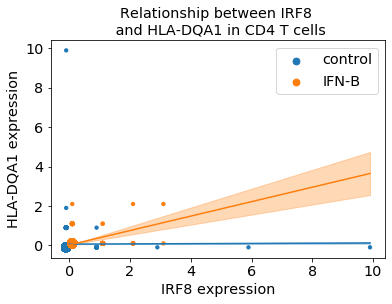

In [56]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, ct, 'IRF8', 'HLA-DQA1', offset=0.1)

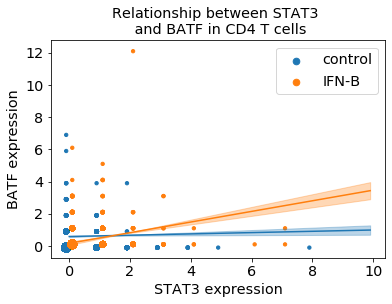

In [61]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, 'CD4 T cells', 'STAT3', 'BATF', offset=0.1)

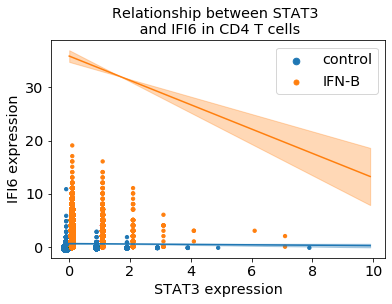

In [62]:
plot_diff_corr(dc_result, corr_ci, moment_dict_1d, 'CD4 T cells', 'STAT3', 'IFI6', offset=0.1)